# Quickstart example for cancer simulation 
This notebook illustrates how to run a 2D cancer simulation using CancerSim. 

The simulation parameters are provided through the CancerSimulationParameters API. 

The simulation treats a 2D tumour on a 20x20 grid for 10 generations. Healthy cells and cancer cells differ by their division probabilities (0.5 vs 0.8), death probabilities (0.1 vs. 0.4), and mutation probabilities (0.2 vs. 0.8). The first cancer cell carries 2 mutations, new mutations occur with a 20% probability and 10 fold abundance. Advantageous mutations only occur every 30000th generation, i.e. they are very unlikely to occur within the simulation run. We sample 10% of the tumour at a read depth of 100.

After the run, we plot the tumour growth curve and the mutation frequency histograms for the whole tumour and the sampled tumour.

## Import modules 

In [15]:
# The cancer simulation module.
from casim import casim

In [16]:
#  3rd party modules.
import os, shutil
from wand.image import Image as WImage

## Setup parameters 

In [19]:
parameters=casim.CancerSimulatorParameters(
                                matrix_size=20,
                                number_of_generations=10,
                                division_probability=0.5,
                                adv_mutant_division_probability=0.8,
                                death_probability=0.1,
                                adv_mutant_death_probability=0.4,
                                mutation_probability=0.2,
                                adv_mutant_mutation_probability=0.8,
                                mutations_per_division=10,
                                adv_mutation_interval=30000,
                                number_of_initital_mutations=2,
                                sampling_fraction=0.1,
                                plot_tumour_growth=True,
                                export_tumour=True
                               )

## Setup the simulation engine. 

In [20]:
if os.path.isdir('out'):
    shutil.rmtree('out')

In [21]:
cancer_sim = casim.CancerSimulator(parameters, seed=1, outdir='out/')

## Run the simulation 

In [22]:
cancer_sim.run()

0

<Figure size 432x288 with 0 Axes>

## Display results. 

In [23]:
image_path=os.path.join(cancer_sim.outdir,'cancer_1', 'simOutput', 'growthCurve.pdf')

In [24]:
img = WImage(filename=image_path)

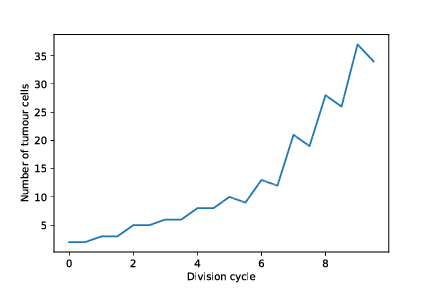

In [25]:
display(img)

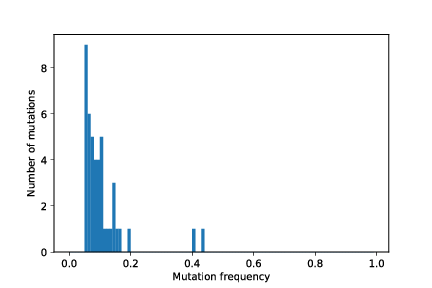

In [26]:
display(WImage(filename=os.path.join(cancer_sim.outdir,'cancer_1', 'simOutput', 'wholeTumourVAFHistogram.pdf')))

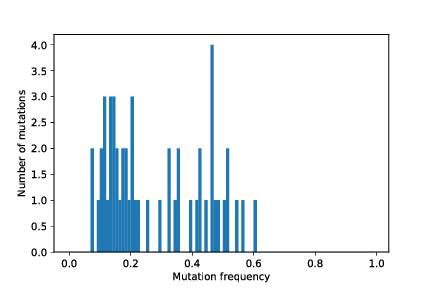

In [29]:
display(WImage(filename=os.path.join(cancer_sim.outdir,'cancer_1', 'simOutput', 'sampleHistogram_7_13.pdf')))